# Calculation of Relative Permeability

Estimation of relative permeability is of high importance in studying multiphase flow through porous media. In this example, we will find the relative permeabilities of fluids during a drainage process. In order to find the relative permeability, we first apply an Invasion Percolation algorithm to understand the behaviour of fluid flow and the saturation distribution of the fluids (which are also called Phases). In the presence of experimental drainage data the capillary pressure curve generated in invasion percolation algorithm can be considered as a validation parameter.

In [23]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt

## Network and Geometry

In [24]:
pn = op.network.Cubic(shape=[25, 25, 25], spacing=0.00006)
geom = op.geometry.StickAndBall(network=pn, pores=pn['pore.all'], throats=pn['throat.all'])

## Phases and Physics

OpenPNM has its predifined phases so that user can use the phases which have already assigned properties. GenericPhase also allows the user to define a generic phase and assign the properties afterwards. Here for the drainage process, we assume oil as the non-wetting fluid and water as the wetting phase.

In [25]:
oil = op.phases.GenericPhase(network=pn)
water = op.phases.GenericPhase(network=pn)
oil['pore.viscosity']=0.000547
oil['throat.contact_angle'] =170
oil['throat.surface_tension'] = 0.072
oil['pore.surface_tension']=0.000072
oil['pore.contact_angle']=170
water['throat.contact_angle'] = 10
water['pore.contact_angle'] = 10
water['throat.surface_tension'] = 0.0000483
water['pore.surface_tension'] = 0.0483
water['pore.viscosity']=0.0004554

In [26]:
phys_water= op.physics.GenericPhysics(network=pn, phase=water, geometry=geom)
phys_oil = op.physics.GenericPhysics(network=pn, phase=oil, geometry=geom)
mod = op.models.physics.hydraulic_conductance.hagen_poiseuille
phys_oil.add_model(propname='throat.hydraulic_conductance',
                              model=mod)
phys_oil.add_model(propname='throat.entry_pressure',
                              model=op.models.physics.capillary_pressure.washburn)
phys_water.add_model(propname='throat.hydraulic_conductance',
                              model=mod)
phys_water.add_model(propname='throat.entry_pressure',
                              model=op.models.physics.capillary_pressure.washburn)

## Invasion Percolation Algorithm for Drainage

We are using [Invasion Percolation](https://openpnm.readthedocs.io/en/master/userguide/algorithms/percolation.html#invasion-percolation) for the Drainage process.

A network in the percolation theory is represented by sites and bonds, the analogy of which are pores and throats in pore network modeling. Based on the fact that which media governs the fluid flow, we can define two mechanisms as bond and site percolation. A site mechanism indicates a process in which each site can be "open" or "close". Open sites can convey the phase of interest (e.g. electricity, fluid, bacteria). Here, open sites are open to [invading fluid](https://www.crcpress.com/Applications-Of-Percolation-Theory/Sahini-Sahimi/p/book/9780748400768). 

In drainage process, where throats govern the flow, open pores are large and they convey the non-wetting phase. The idea is when the applied pressure reaches greater than the throat entry pressure, it flows through the throat. Recalling the fact that each throat has equal or smaller size of its both pores, the fluid can then enter the pores. Here, large pores do not provide problem as long as the applied pressure is high enough (at least equal to throat entry pressure which is always lower or equal to pore entry pressure) and the process is controlled by smaller medium [throats](http://www.geomatejournal.com/node/1007). 

The Invasion Percolation Algorithm in openpnm basically is a bond percolation mechanism. In order to enjoy both site and bond mechanism a Mixed Invasion Percolation module is provided in openpnm. Here, we get the results of inv algorithm and plot the Pc-S curve with a couple of simple commands. The idea is the IP returns occupancy of each pore and throat at any user defined saturation for invading phase. For an arbitrary range of saturation in the range of [0,1] once we find the capillary pressure, the intrusion curve is found. For each saturation the highest entry pressure among the invaded pores indicates the capillary pressure at that saturation. The follwing script shows the procedure:

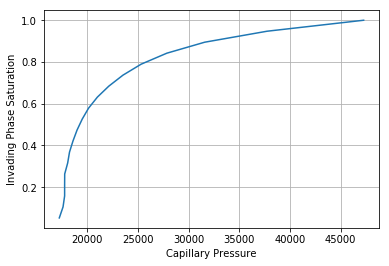

In [27]:
inv=op.algorithms.InvasionPercolation(phase=oil,network=pn)
inv.setup(phase=oil,entry_pressure='throat.entry_pressure',pore_volume='pore.volume', throat_volume='throat.volume')
inlets = pn.pores(['top'])
used_inlets = [inlets[x] for x in range(0, len(inlets), 2)]
inv.set_inlets(pores=used_inlets)
inv.run()
Snwparr =  []
Pcarr =  []
Sarr=np.linspace(0,1,num=20)
for Snw in Sarr:
    res1=inv.results(Snwp=Snw)
    occ_ts=res1['throat.occupancy']
    if np.any(occ_ts):
        max_pthroat=np.max(phys_oil['throat.entry_pressure'][occ_ts])
        Pcarr.append(max_pthroat)
        Snwparr.append(Snw)
Sat=np.array(Snwparr[:])
Pc=np.array(Pcarr[:])
plt.figure(1)
plt.plot(Pc, Sat)
plt.xlabel('Capillary Pressure')
plt.ylabel('Invading Phase Saturation')
plt.grid(True)

## Permeability Calculation Algorithm

The StokesFlow class is for simulation of viscous flow. In this class default property names will be set. The main role of this class would be calculation of the hydraulic permeability. Having its effective permeability calculation method, it can deal with nonuniform medias.

We first find single phase permeability where the stokes flow is implemented for each phase as if it is the only phase flowing through the porous media. Theis is done as the conductance is the hydraulic conductance. Otherwise, it will change to multiphase conduit conductance. Note that we have defined perm_water and perm_oil in a dictionary so that we have a permeability tensor (directional permeability).
-For the permeability calculation, we need to set inlets and outlets of the media, both of which can be defined by introducing some pores as boundary surface pores.

As we have mentioned the permeability will be a tensor, which represents $K_x,K_y,K_z$. Permeability tensor plays an important role in anisotropic medias charactarization. We have defined relative permeabilities in 1 direction. It can be adjusted for three dimensions defining a dictionary.

In [29]:
[amax, bmax, cmax] = np.max(pn['pore.coords'], axis=0)
[amin, bmin, cmin] = np.min(pn['pore.coords'], axis=0)
lx = amax-amin
ly = bmax-bmin
lz = cmax-cmin
da = lx*ly
dl = lz

def top_b(lx,ly,lz):
    da = lx*ly
    dl = lz
    res_2=[da,dl]
    return res_2

[da, dl]= top_b(lx,ly,lz)
BC1_pores = pn.pores(labels='top')
BC2_pores = pn.pores(labels='bottom')
# single phase water permeability
Stokes_sp_w = op.algorithms.StokesFlow(network=pn, phase=water)
Stokes_sp_w.setup(conductance='throat.hydraulic_conductance')
Stokes_sp_w._set_BC(pores=BC1_pores, bctype='value', bcvalues=1)
Stokes_sp_w._set_BC(pores=BC2_pores, bctype='value', bcvalues=0)
Stokes_sp_w.run()
K_sp_w = Stokes_sp_w.calc_effective_permeability(domain_area=da, domain_length=dl)
# single phase oil permeability
Stokes_sp_o = op.algorithms.StokesFlow(network=pn, phase=oil)
Stokes_sp_o.setup(conductance='throat.hydraulic_conductance')
Stokes_sp_o._set_BC(pores=BC1_pores, bctype='value', bcvalues=1)
Stokes_sp_o._set_BC(pores=BC2_pores, bctype='value', bcvalues=0)
Stokes_sp_o.run()
K_sp_o = Stokes_sp_o.calc_effective_permeability(domain_area=da, domain_length=dl)

## Relative Permeability Calculation Algorithm

In order to find the relative permeability of oil and water, we use stokes algorithm which calculates the effective permeability of the media. The trick is if we find the effective permeability of a single phase and find its effective permeability in multiphase condition, the ratio of multiphase to single phase property gives us the relative property, here the relative permeability. The multiphase parameters (here the conduit hydraulic conductance) change as the occupancy changes. Therefore at each increment of the invasion, we have to update some properties of physics and phase model then apply the fluid flow algorithm with updated values of models. 

The follwing code is the function for updating the physics.

In [30]:
def update_phase_and_phys(results):
    oil['pore.occupancy'] = results['pore.occupancy']
    water['pore.occupancy'] = 1-results['pore.occupancy']
    oil['throat.occupancy'] = results['throat.occupancy']
    water['throat.occupancy'] = 1-results['throat.occupancy']
    # adding multiphase conductances
    mode='strict'
    phys_water.add_model(model=op.models.physics.multiphase.conduit_conductance,
                       propname='throat.conduit_hydraulic_conductance',
                       throat_conductance='throat.hydraulic_conductance',
                       mode=mode)
    phys_oil.add_model(model=op.models.physics.multiphase.conduit_conductance,
                         propname='throat.conduit_hydraulic_conductance',
                         throat_conductance='throat.hydraulic_conductance',
                         mode=mode)

The following loop is related to the relative permeability calculation. We implement stokes flow algorithm considering the fact that the other phase is also existed in the pores. The existance of other phase will affect the conductance area of the pores and throats. Considering the phase ocuppancy, we use 'throat.conduit_hydraulic_conductance' for the calculation of the permeability of the phase in a multiphase flow problem. The ratio of this effective permeability to the absolute permeability (given in the previous step) gives the relative permeability of that phase.

In [31]:
K_rel_w=[]
K_rel_o=[]
for Sp in Sat:
    update_phase_and_phys(inv.results(Snwp=Sp))
    print('Sat is equal to', Sp)
    # Multiphase flow
    # water
    Stokes_mp_w = op.algorithms.StokesFlow(network=pn,phase=water)
    Stokes_mp_w.setup(conductance='throat.conduit_hydraulic_conductance')
    Stokes_mp_w.set_value_BC(values=1, pores=BC1_pores)
    Stokes_mp_w.set_value_BC(values=0, pores=BC2_pores)
    # oil
    Stokes_mp_o = op.algorithms.StokesFlow(network=pn,phase=oil)
    Stokes_mp_o.setup(conductance='throat.conduit_hydraulic_conductance')
    Stokes_mp_o.set_value_BC(values=1, pores=BC1_pores)
    Stokes_mp_o.set_value_BC(values=0, pores=BC2_pores)
    # Find Multiphase effective permeability
    Stokes_mp_w.run()
    K_mp_w = Stokes_mp_w.calc_effective_permeability(domain_area=da, domain_length=dl)
    Stokes_mp_o.run()
    K_mp_o = Stokes_mp_o.calc_effective_permeability(domain_area=da, domain_length=dl)
    # Calculate relative effective permeability for the saturation point Sp
    Kr_eff_w = K_mp_w/K_sp_w
    Kr_eff_o = K_mp_o/K_sp_o
    # Add K_rel to the relative permeability array which is considered to be an array
    # of relative permeabilities corresponding to saturation points in Sat
    K_rel_w.append(Kr_eff_w)
    K_rel_o.append(Kr_eff_o)

Sat is equal to 0.05263157894736842
Sat is equal to 0.10526315789473684
Sat is equal to 0.15789473684210525
Sat is equal to 0.21052631578947367
Sat is equal to 0.2631578947368421
Sat is equal to 0.3157894736842105
Sat is equal to 0.3684210526315789
Sat is equal to 0.42105263157894735
Sat is equal to 0.47368421052631576
Sat is equal to 0.5263157894736842
Sat is equal to 0.5789473684210527
Sat is equal to 0.631578947368421
Sat is equal to 0.6842105263157894
Sat is equal to 0.7368421052631579
Sat is equal to 0.7894736842105263
Sat is equal to 0.8421052631578947
Sat is equal to 0.894736842105263
Sat is equal to 0.9473684210526315
Sat is equal to 1.0


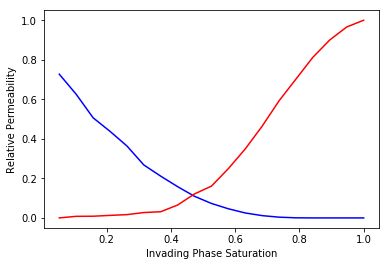

In [32]:
plt.figure(2)
plt.plot(Sat, K_rel_w,'b')
plt.xlabel('Invading Phase Saturation')
plt.ylabel('Relative Permeability')
plt.plot(Sat, K_rel_o,'r')